In [1]:
import shap
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import lime
from tqdm import tqdm
from xai_utils import *

/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data.head()

name lang  bot           created_at  statuses_count  \
2353593986   Lamonica Raborn   en    1  2019-02-22 18:00:42              76   
2358850842     Lourie Botton   en    0  2019-02-26 03:02:32              54   
137959629   Dadan Syarifudin   en    1  2015-04-30 07:09:56              53   
466124818     Carletto Focia   it    1  2017-01-18 02:49:18              50   
2571493866         MBK Ebook   en    0  2019-06-18 19:30:21            7085   

            avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
2353593986   62.340909          14.015152    0.000000        0.272727   
2358850842   69.082645          15.041322    0.000000        0.338843   
137959629    65.340909          14.694444    0.000000        0.000000   
466124818    86.944871          18.689463    0.022331        0.006281   
2571493866   72.311246          14.582073    0.000825        0.506461   

            hashtags_ratio  reply_count_mean  reply_count_std  \
2353593986        0.098485               0.0              0.0   
2358850842        0.024793               0.0              0.0   
137959629         0.000000               0.0              0.0   
466124818         0.072575               0.0              0.0   
2571493866        0.118229               0.0              0.0   

            favorite_count_mean  favorite_count_std  favorite_count_entropy  \
2353593986             0.037879            0.190903                0.232481   
2358850842             0.049587            0.217090                0.284639   
137959629              0.000000            0.000000                0.000000   
466124818              0.165387            0.530838                0.669155   
2571493866             0.056365            0.243387                0.317182   

            retweet_count_mean  retweet_count_std  retweet_count_entropy  
2353593986            0.037879           0.190903               0.232481  
2358850842            0.024793           0.155495               0.167568  
137959629             0.000000           0.000000              -0.000000  
466124818             0.826239          13.034008               0.392850  
2571493866            0.016772           0.142619               0.120737

In [4]:
#a descrption of the dataset
data.describe()

bot  statuses_count    avg_length  avg_special_chars  \
count  11508.000000    11508.000000  11508.000000       11508.000000   
mean       0.531456     5148.794751     67.100135          15.045892   
std        0.499031    18496.606420     12.755296           2.454106   
min        0.000000        0.000000     32.500000           9.644166   
25%        0.000000       53.000000     59.686796          13.553296   
50%        1.000000       57.000000     65.340909          14.694444   
75%        1.000000     2041.000000     74.254999          16.772205   
max        1.000000   399555.000000    104.449541          22.000000   

         urls_ratio  mentions_ratio  hashtags_ratio  reply_count_mean  \
count  11508.000000    11508.000000    11508.000000      11508.000000   
mean       0.031045        0.347537        0.101921          0.001967   
std        0.053379        0.343735        0.093837          0.007796   
min        0.000000        0.000000        0.000000          0.000000   
25%        0.000000        0.010260        0.045455          0.000000   
50%        0.005109        0.303797        0.073394          0.000000   
75%        0.037445        0.500000        0.128810          0.000000   
max        0.287760        1.726592        0.478261          0.044444   

       reply_count_std  favorite_count_mean  favorite_count_std  \
count     11508.000000         11508.000000        11508.000000   
mean          0.023941             0.084282            0.365569   
std           0.068508             0.109623            0.408441   
min           0.000000             0.000000            0.000000   
25%           0.000000             0.017751            0.136692   
50%           0.000000             0.045752            0.230747   
75%           0.000000             0.088862            0.451218   
max           0.333767             0.529903            2.183383   

       favorite_count_entropy  retweet_count_mean  retweet_count_std  \
count            11508.000000        11508.000000       11508.000000   
mean                 0.385430           98.347409         361.956697   
std                  0.390787          329.248000         626.207734   
min                  0.000000            0.000000           0.000000   
25%                  0.119116            0.022901           0.151796   
50%                  0.268594            0.096931           0.437106   
75%                  0.491767           74.499524         533.013057   
max                  1.723913        14432.000000        5442.443396   

       retweet_count_entropy  
count           11508.000000  
mean                1.011612  
std                 1.412183  
min                -0.000000  
25%                 0.136059  
50%                 0.312150  
75%                 1.462435  
max                 9.161105

In [5]:
train_set, test_set, train_label, test_label = prepare_data(data)

Features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy']


In [6]:
features = test_set.columns.to_list()

In [7]:
scaler = StandardScaler()

train_X = scaler.fit_transform(train_set)
test_X = scaler.transform(test_set)

In [8]:
with open("../models_checkpoints/nn_no_lang.bin", "rb") as f:
    nn_model = pickle.load(f)

Trying to unpickle estimator LabelBinarizer from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPClassifier from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [9]:
nn_model

MLPClassifier(hidden_layer_sizes=[16, 8], learning_rate_init=0.01, max_iter=100,
              momentum=0.1, random_state=8)

## Explain the results: SHAP

In [10]:
shap.initjs()

In [11]:
explainer = shap.KernelExplainer(nn_model.predict_proba, shap.sample(train_X, 20))

In [12]:
shap_values = explainer.shap_values(test_X[0:200])

  0%|                                                                                                                                                                                                                                                   | 0/200 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

  3%|███████                                                                                                                                                                                                                                    | 6/200 [00:01<00:44,  4.36it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

  6%|██████████████                                                                                                                                                                                                                            | 12/200 [00:02<00:47,  3.94it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

  9%|█████████████████████                                                                                                                                                                                                                     | 18/200 [00:04<00:42,  4.26it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 12%|████████████████████████████                                                                                                                                                                                                              | 24/200 [00:05<00:40,  4.38it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 15%|███████████████████████████████████                                                                                                                                                                                                       | 30/200 [00:07<00:39,  4.29it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 18%|██████████████████████████████████████████                                                                                                                                                                                                | 36/200 [00:08<00:40,  4.08it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 21%|█████████████████████████████████████████████████▏                                                                                                                                                                                        | 42/200 [00:09<00:36,  4.32it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 24%|████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 48/200 [00:11<00:33,  4.59it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 27%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 54/200 [00:12<00:35,  4.15it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 60/200 [00:14<00:33,  4.15it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 33%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 66/200 [00:15<00:30,  4.33it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 36%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 72/200 [00:16<00:31,  4.10it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 39%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 78/200 [00:18<00:28,  4.31it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 84/200 [00:19<00:27,  4.19it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 90/200 [00:21<00:25,  4.24it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 96/200 [00:22<00:25,  4.05it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 102/200 [00:24<00:23,  4.24it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 108/200 [00:25<00:19,  4.61it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 113/200 [00:26<00:19,  4.39it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 119/200 [00:27<00:17,  4.58it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 125/200 [00:29<00:15,  4.76it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 131/200 [00:30<00:14,  4.84it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 136/200 [00:31<00:13,  4.75it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 142/200 [00:32<00:11,  4.87it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 147/200 [00:33<00:10,  4.88it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 153/200 [00:35<00:09,  4.79it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 159/200 [00:36<00:08,  4.88it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 164/200 [00:37<00:07,  4.85it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 170/200 [00:38<00:06,  4.90it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 176/200 [00:39<00:05,  4.79it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 182/200 [00:41<00:03,  4.82it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 187/200 [00:42<00:02,  4.80it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 193/200 [00:43<00:01,  4.85it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 198/200 [00:44<00:00,  4.38it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you 

In [13]:
shap.force_plot(explainer.expected_value[0], shap_values[0], test_X, link="logit",feature_names=features)

In [14]:
shap.force_plot(explainer.expected_value[1], shap_values[1], test_X, link="logit",feature_names=features)

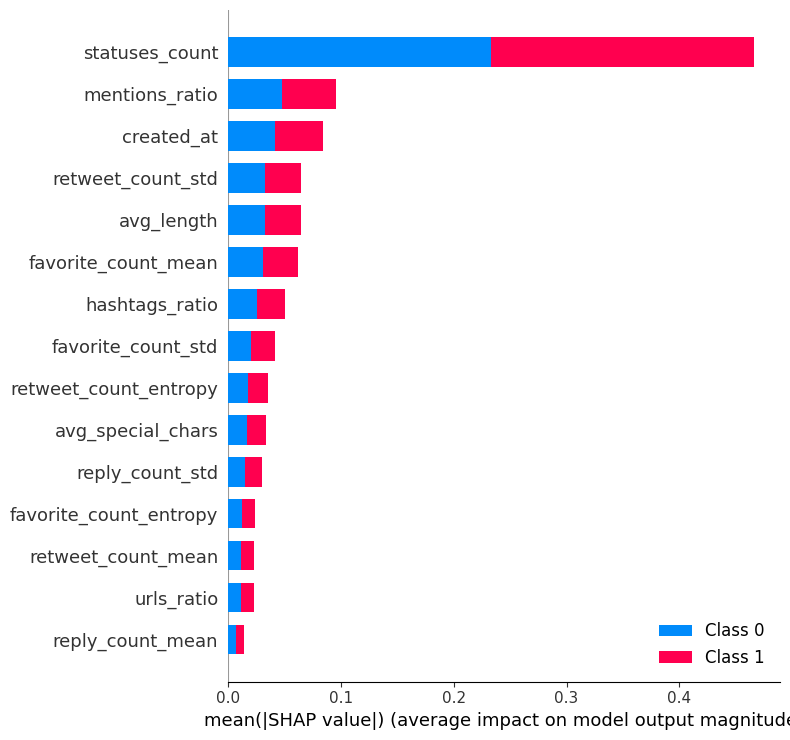

In [15]:
shap.summary_plot(shap_values, test_X[0:200], feature_names=features)

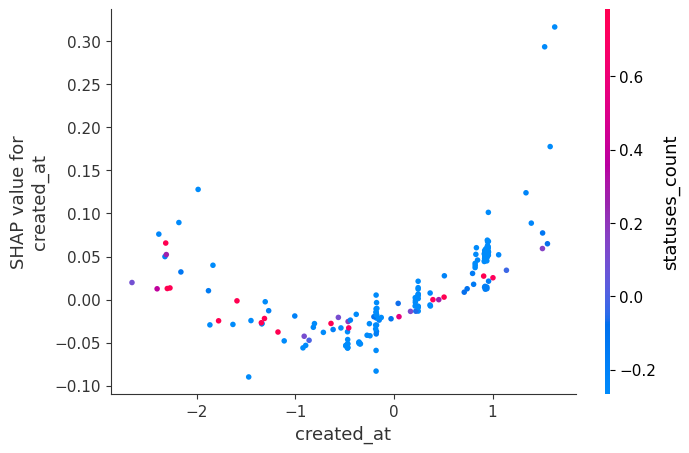

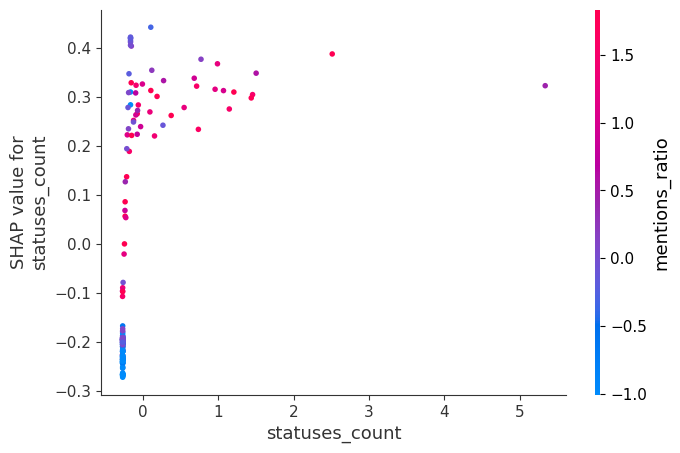

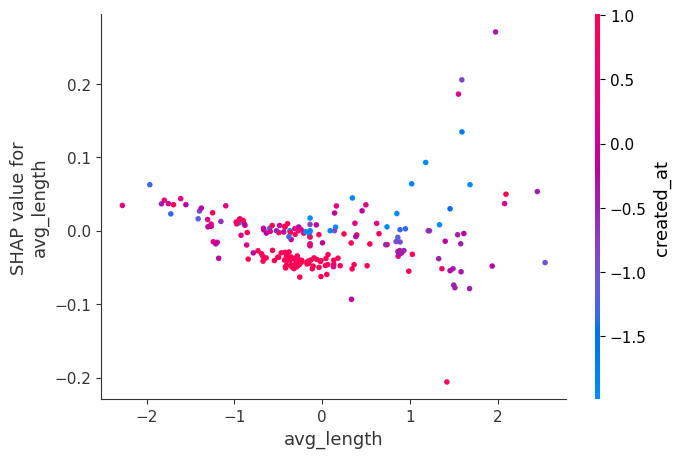

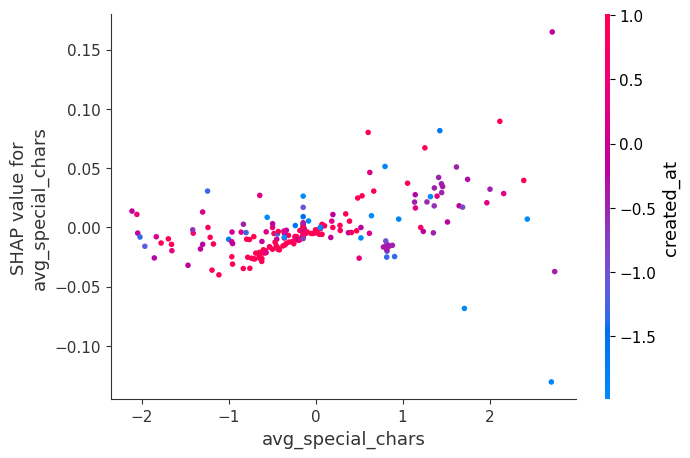

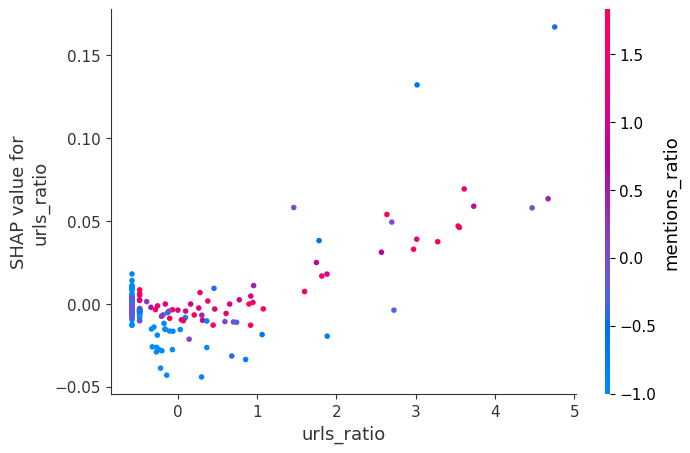

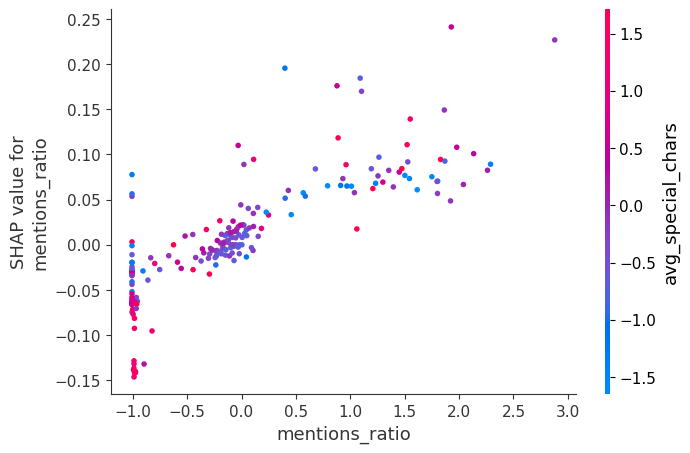

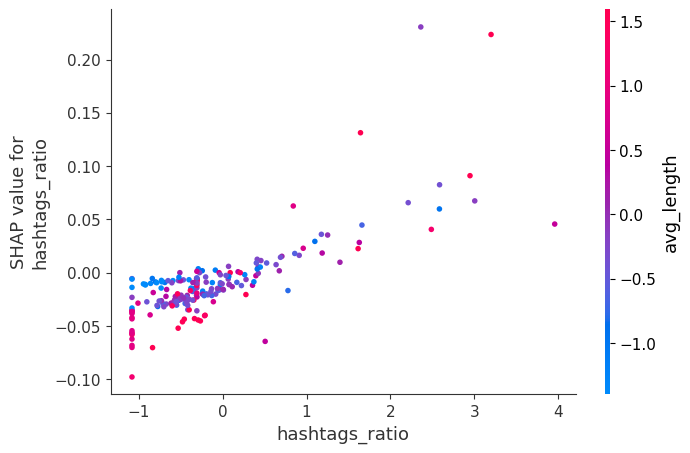

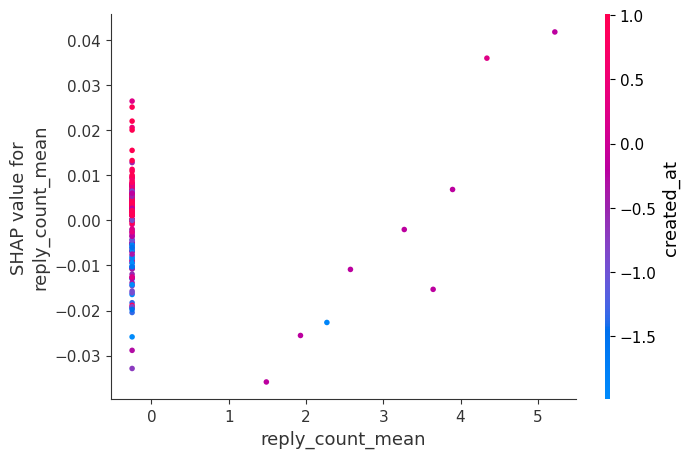

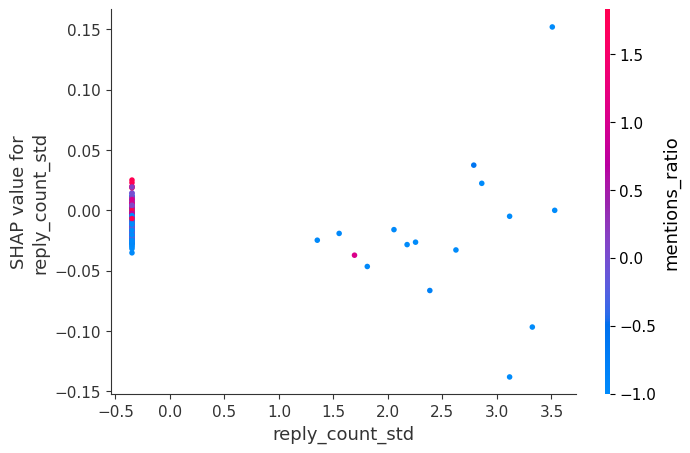

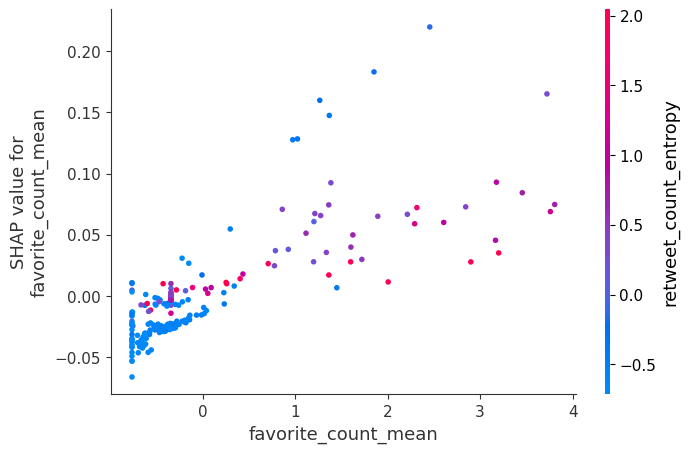

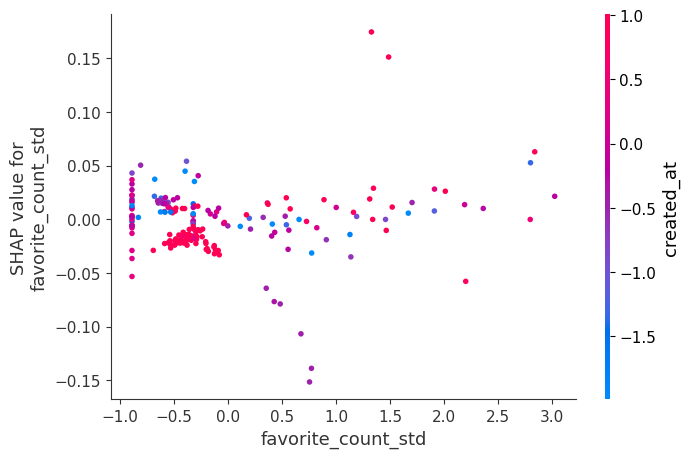

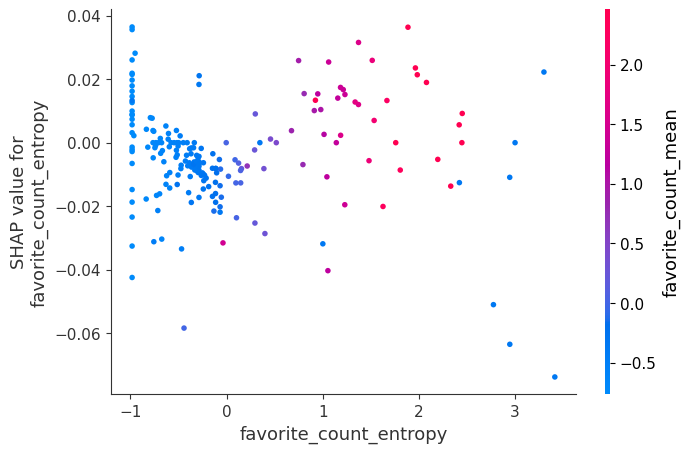

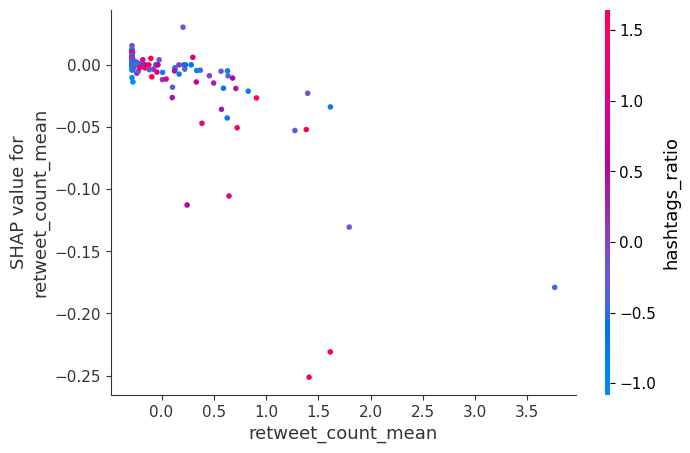

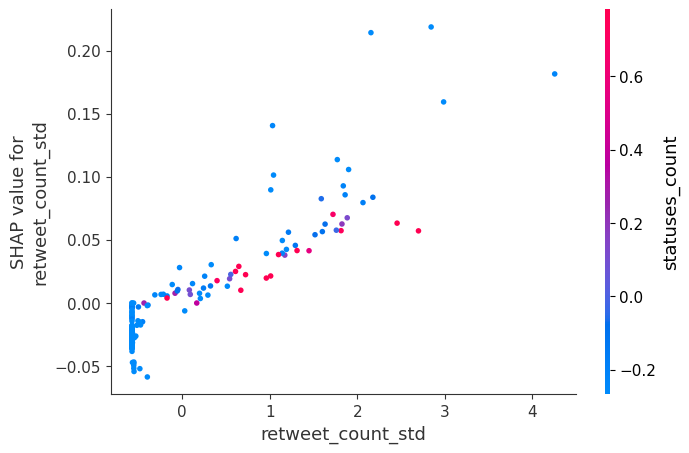

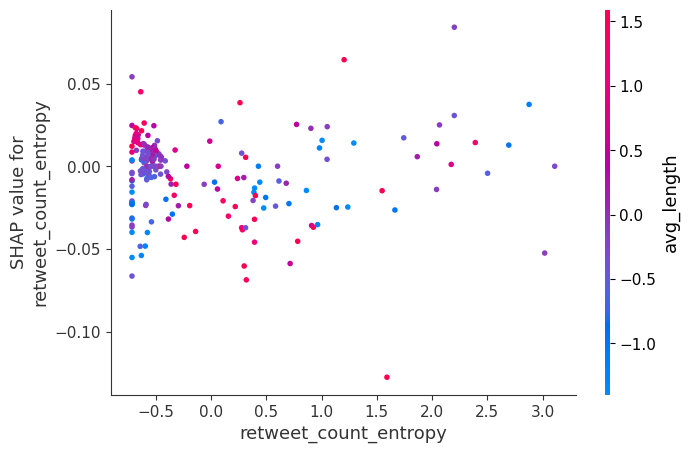

In [16]:
for feat in features:
    shap.dependence_plot(
        feat,
        shap_values[0], test_X[0:200], feature_names=features)

### Local Explain

In [17]:
pd.Series(test_X[12], features)

created_at                0.215168
statuses_count           -0.266157
avg_length                0.373491
avg_special_chars         0.618178
urls_ratio               -0.579392
mentions_ratio           -1.006791
hashtags_ratio            0.183286
reply_count_mean         -0.250709
reply_count_std          -0.347567
favorite_count_mean      -0.766311
favorite_count_std       -0.890723
favorite_count_entropy   -0.983043
retweet_count_mean       -0.283026
retweet_count_std        -0.574892
retweet_count_entropy    -0.715023
dtype: float64

In [18]:
nn_model.predict([test_X[12]])

array([1])

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][12,:], feature_names=test_set.columns.to_list())

In [20]:
pd.Series(test_X[1], features)

created_at                1.556007
statuses_count           -0.073662
avg_length               -1.247249
avg_special_chars        -1.692170
urls_ratio                1.747507
mentions_ratio            0.791255
hashtags_ratio            0.263055
reply_count_mean         -0.250709
reply_count_std          -0.347567
favorite_count_mean       0.090244
favorite_count_std        0.168709
favorite_count_entropy    0.124274
retweet_count_mean        0.498680
retweet_count_std         1.631694
retweet_count_entropy     0.981248
dtype: float64

In [21]:
nn_model.predict([test_X[1]])

array([0])

In [22]:
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], feature_names=test_set.columns.to_list())

## Explain Model: LIME

In [23]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(train_X, feature_names = features)

In [36]:
exp = lime_explainer.explain_instance(test_X[0], nn_model.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

In [34]:
exp = lime_explainer.explain_instance(test_X[1], nn_model.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=True)

## Explain Model: Evaluation

### Lime

In [26]:
exp.local_exp

{1: [(1, 0.13864232407702495),
  (8, 0.07968808764559002),
  (7, 0.04751723795310529),
  (6, 0.03099900715935835),
  (2, 0.016810884977611795),
  (11, 0.01537396415157185),
  (4, 0.012790884100695213),
  (13, 0.012305792147137656),
  (0, -0.012096838521092605),
  (3, -0.010629313458348956)]}

In [27]:
from aix360.metrics import faithfulness_metric, monotonicity_metric

predicted_class = nn_model.predict([test_X[0]])[0]

le = exp.local_exp[predicted_class]

m = exp.as_map()

x = test_X[0]
coefs = np.zeros(x.shape[0])

for v in le:
    coefs[v[0]] = v[1]


base = np.zeros(x.shape[0])


print("Faithfulness: ", faithfulness_metric(nn_model, x, coefs, base))
print("Monotonity: ", monotonicity_metric(nn_model, x, coefs, base))

Faithfulness:  0.7225932700811892
Monotonity:  False


In [28]:
ncases = 100
fait = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = nn_model.predict(test_X[i].reshape(1,-1))[0]
    exp = lime_explainer.explain_instance(test_X[i], nn_model.predict_proba, top_labels=1)
    le = exp.local_exp[predicted_class]
    m = exp.as_map()
    
    x = test_set.values[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
        coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(nn_model, test_X[i], coefs, base)
    
fait[np.isnan(fait)] = 0

 16%|█████████████████████████████████████▍                                                                                                                                                                                                    | 16/100 [00:01<00:04, 16.85it/s]invalid value encountered in divide
invalid value encountered in divide
 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 68/100 [00:04<00:02, 15.84it/s]invalid value encountered in divide
invalid value encountered in divide
 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 78/100 [00:05<00:01, 16.19it/s]invalid value encountered in divide
inva

In [29]:
print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))

Faithfulness metric mean:  0.6193934655229956
Faithfulness metric std. dev.: 0.3911898656852545


### Shap

In [30]:
print("Faithfulness: ", faithfulness_metric(nn_model, test_X[1], shap_values[nn_model.predict([test_X[1]])[0]][1], base))
print("Monotonity: ", monotonicity_metric(nn_model, x, shap_values[predicted_class][1], base))

Faithfulness:  0.15371452676278466
Monotonity:  True


In [31]:
ncases = 100 # max shap values istances
fait = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = nn_model.predict(test_X[i].reshape(1,-1))[0]
    fait[i] = faithfulness_metric(nn_model, test_X[i], shap_values[predicted_class][i], base)

fait[np.isnan(fait)] = 0

  0%|                                                                                                                                                                                                                                                   | 0/100 [00:00<?, ?it/s]invalid value encountered in divide
invalid value encountered in divide
 40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 40/100 [00:00<00:00, 395.82it/s]invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1

In [32]:
print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))

Faithfulness metric mean:  0.7251908489393638
Faithfulness metric std. dev.: 0.37219558790934176
